# Netflix Recommendation System

In [42]:
import sys
import os
import cornac
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cornac.models import UserKNN, ItemKNN
from cornac.eval_methods import RatioSplit
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
import time
from sklearn.metrics import precision_recall_curve, mean_squared_error, mean_absolute_error
import numpy as np
from itertools import product
from collections import defaultdict
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
import numpy as np

SEED = 42
VERBOSE = False

In [9]:
sys.path.append(os.path.abspath(os.path.join('..')))

## Exploring the Data

In [10]:
from data.data import load_netflix_data
feedback = load_netflix_data()

Loaded dataset:
Type: <class 'list'>
Number of entries: 607803


In [11]:
print('Type of dataset:', type(feedback))
print('Entry example:', feedback[0])

Type of dataset: <class 'list'>
Entry example: ('2567280', '2', 3.0)


In [12]:
df = pd.DataFrame(feedback, columns=['userid', 'itemid', 'rating'])
df['userid'] = df['userid'].astype(int)  
df['itemid'] = df['itemid'].astype(int)
df['rating'] = df['rating'].astype(float)

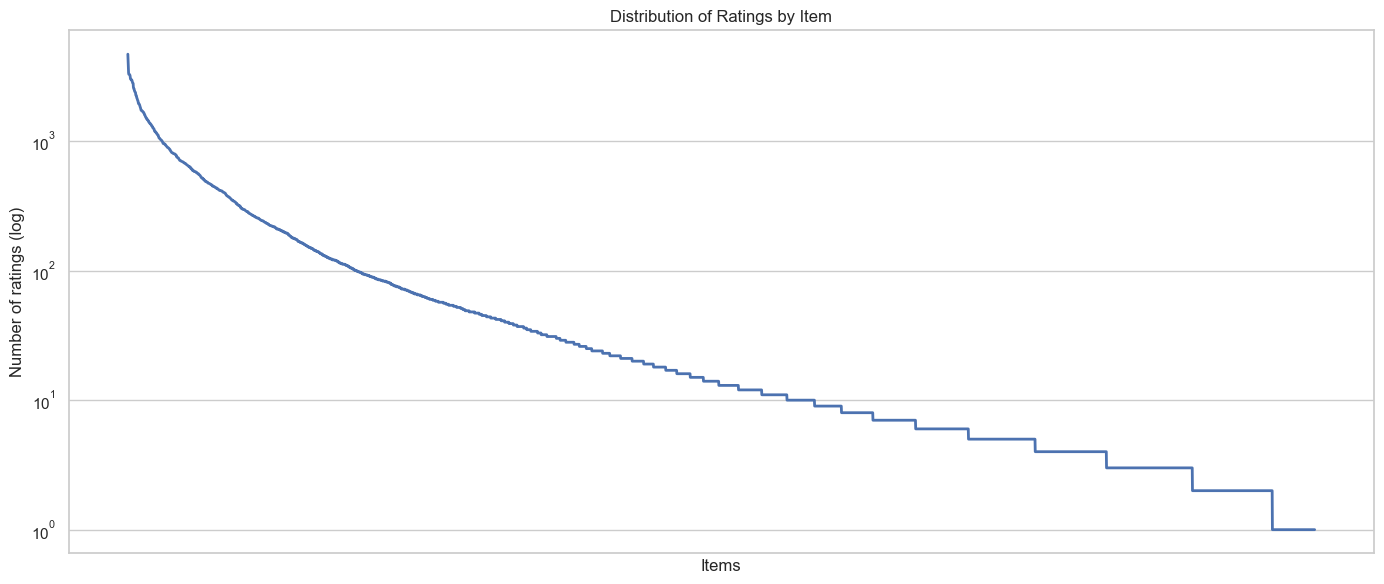

In [13]:
sns.set(style='whitegrid')

# Count ratings by item and sort
item_counts = df.groupby('itemid')['rating'].count().sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=item_counts, linewidth=2)
plt.yscale('log') 
plt.xticks([], [])

plt.xlabel('Items')
plt.ylabel('Number of ratings (log)')
plt.title('Distribution of Ratings by Item')
plt.tight_layout()
plt.show()

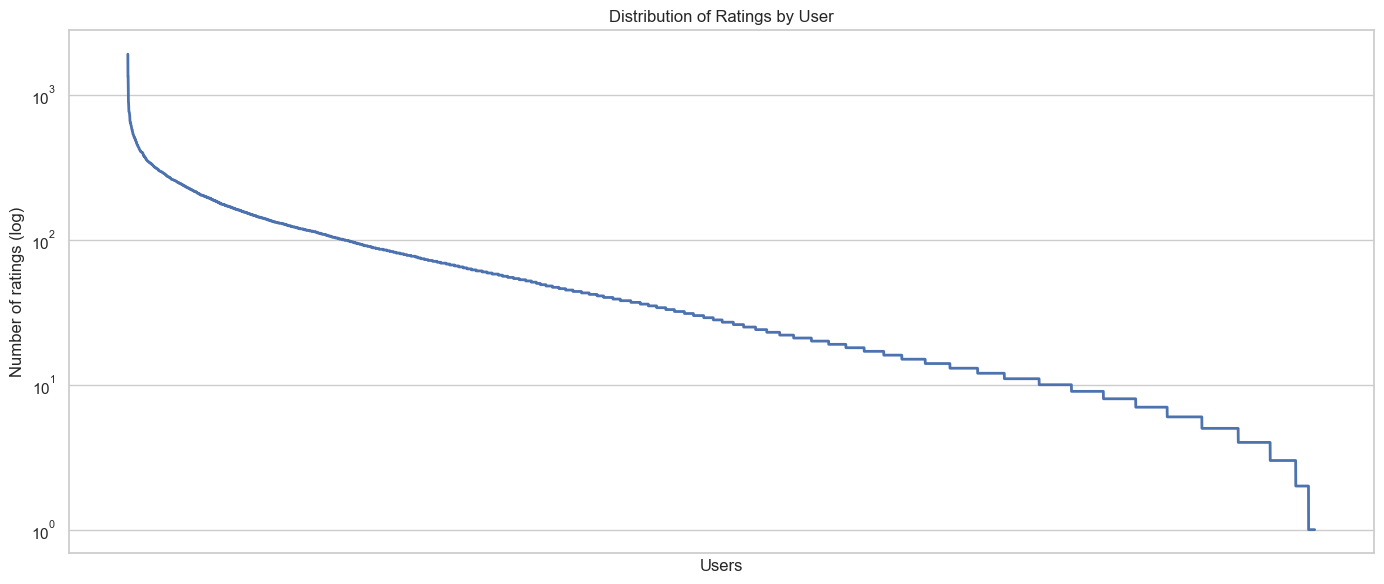

In [14]:
sns.set(style='whitegrid')

# Count ratings by user and sort
user_counts = df.groupby('userid')['rating'].count().sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=user_counts, linewidth=2)
plt.yscale('log')

plt.xlabel('Users')
plt.ylabel('Number of ratings (log)')
plt.title('Distribution of Ratings by User')

plt.xticks([], [])

plt.tight_layout()
plt.show()


In [15]:
# Data sparsity
n_users = df.userid.nunique()
n_items = df.itemid.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"Sparsity: {sparsity * 100.0:.2f}%")

Number of users: 9992
Number of items: 4945
Number of available ratings: 607803
Number of all possible ratings: 49410440
----------------------------------------
Sparsity: 98.77%


## User-Based and Item-Based Recommendations

We will start the Recommendation System by creating user-based and item-based recommendations. User-based and item-based collaborative filtering methods are intuitive approaches that use similarities between users or items to generate recommendations. These methods are useful as they require no prior knowledge about the items and can adapt dynamically to user preferences.

In [16]:
metrics = [cornac.metrics.RMSE(), 
           cornac.metrics.MAE(),
           cornac.metrics.Precision(k=10),
           cornac.metrics.Recall(k=10),
]

### User-Based

In [17]:
# UserKNN methods

K = 50
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=metrics,
).run()


TEST:
...
                   |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) |  Test (s)
------------------ + ------ + ------ + ------------ + --------- + --------- + ---------
UserKNN-Cosine     | 0.7701 | 0.8771 |       0.0001 |    0.0000 |    6.1433 |  205.1300
UserKNN-Cosine-MC  | 0.7671 | 0.8751 |       0.0000 |    0.0000 |    5.4346 |  207.9948
UserKNN-Pearson    | 0.7671 | 0.8751 |       0.0000 |    0.0000 |    5.2574 | 1132.3496
UserKNN-Pearson-MC | 0.7671 | 0.8751 |       0.0000 |    0.0000 |    5.7513 |  212.6652



### Item-Based

In [18]:
# ItemKNN methods

K = 50
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=metrics
).run()


TEST:
...
                       |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) |  Test (s)
---------------------- + ------ + ------ + ------------ + --------- + --------- + ---------
ItemKNN-Cosine         | 0.8120 | 0.9225 |       0.0035 |    0.0016 |    1.5266 |  170.6812
ItemKNN-Pearson        | 0.8041 | 0.9103 |       0.0002 |    0.0001 |    1.6517 |  165.2815
ItemKNN-Pearson-MC     | 0.7964 | 0.9040 |       0.0013 |    0.0010 |    1.7418 |  168.2484
ItemKNN-AdjustedCosine | 0.7683 | 0.8749 |       0.0070 |    0.0039 |    1.6887 | 1330.0122



### Making Recommendations

From Cornac experiments above, we select the optimal model for each approach, taking into account not only the obtained metrics, but also training and test times. These are uknn_cosine and iknn_adjusted.

In [19]:
# Create lists with all user ids and item ids from the interactions

user_ids = set()
item_ids = set()

# Each interaction is a tuple (user id, item id, rating)
for interaction in feedback:
    user_ids.add(interaction[0])  
    item_ids.add(interaction[1])  

user_ids = list(user_ids)
item_ids = list(item_ids)

#### Top 10 Recommendations

We will generate dataframes with the top 10 item recommendations for each user, for both user and item based methods. In case the models have not seen a user during training and, therefore, are not able to create recommendations, the items with most interactions will be recommended.

In [20]:
# Obtain top 10 items with more interactions

item_interactions = {}

for interaction in feedback:
    item_id = interaction[1]
    item_interactions[item_id] = item_interactions.get(item_id, 0) + 1

# Sort items by interactions
sorted_items = sorted(item_interactions.items(), key=lambda x: x[1], reverse=True)

top_10_items = sorted_items[:10]
print(f"Top 10 items by number of interactions: {top_10_items}")

top_10_items = [sublist[0] for sublist in top_10_items]

Top 10 items by number of interactions: [('15124', 4692), ('15205', 4195), ('16377', 3910), ('6037', 3368), ('11064', 3283), ('7624', 3280), ('14367', 3280), ('4306', 3268), ('4996', 3249), ('12232', 3215)]


In [21]:
# Create dictionaries (user id: list of recommendations) for both methods, using the optimal models
dict_uknn_recommendations = dict()
dict_iknn_recommendations = dict()

for i in user_ids:
    if uknn_pearson.uid_map.get(i, -1) != -1:
        dict_uknn_recommendations[i] = uknn_pearson.recommend(i, k = 10)  # Top 10 user-based recommendations
    else:
        dict_uknn_recommendations[i] = top_10_items
    if iknn_adjusted.uid_map.get(i, -1) != -1:
        dict_iknn_recommendations[i] = iknn_adjusted.recommend(i, k = 10)  # Top 10 item-based recommendations
    else:
        dict_iknn_recommendations[i] = top_10_items

In [22]:
uknn_recommendations = pd.DataFrame(list(dict_uknn_recommendations.items()), columns=["userid", "uknn_recommendations"])
uknn_recommendations.head(10)

userid                               uknn_recommendations
0   643967  [10307, 11816, 13455, 12050, 13312, 4875, 1669...
1   129204  [8546, 3897, 9386, 15602, 12050, 15510, 14626,...
2     5126  [14626, 10307, 3897, 13455, 987, 17577, 12050,...
3   227277  [14626, 10307, 8546, 3897, 2681, 1227, 1133, 1...
4  2199476  [5575, 1996, 11675, 14880, 8394, 7353, 17733, ...
5  1670478  [1127, 8546, 3897, 9403, 8195, 3836, 2681, 144...
6   498917  [3897, 1489, 5575, 12544, 4034, 13312, 11200, ...
7  2160350  [4502, 1127, 13429, 15602, 13157, 8195, 16614,...
8  2527523  [1127, 15793, 15602, 11288, 12050, 8323, 4502,...
9   175587  [7353, 8394, 9755, 15793, 13455, 15602, 4502, ...

In [23]:
iknn_recommendations = pd.DataFrame(list(dict_iknn_recommendations.items()), columns=["userid", "iknn_recommendations"])
iknn_recommendations.head(10)

userid                               iknn_recommendations
0   643967  [8015, 6217, 15478, 3800, 8913, 312, 14626, 13...
1   129204  [17105, 10651, 15111, 793, 3302, 2780, 843, 11...
2     5126  [6217, 10651, 14626, 3897, 12050, 4314, 10602,...
3   227277  [2, 4132, 2681, 7845, 1397, 10866, 14626, 6107...
4  2199476  [2973, 11579, 9650, 9166, 10901, 13701, 15744,...
5  1670478  [8971, 193, 3627, 4549, 12258, 9018, 14374, 25...
6   498917  [11431, 11200, 12740, 17753, 8735, 7325, 6391,...
7  2160350  [5241, 13895, 13798, 3633, 2651, 12410, 2203, ...
8  2527523  [12050, 6940, 4316, 539, 17473, 5677, 15111, 1...
9   175587  [14902, 17120, 9163, 15589, 2179, 12410, 3994,...

#### Rating Predictions

The relevance metric (Recall@10) of both UKNN and IKNN models is poor, meaning that using Top-K approach might not obtain the best results. Therefore, we enrich the recommendation system with the prediction of ratings, as the models show better performance based on regression metrics, with low RMSE and MAE values.

In [24]:
from src.utils import get_uknn_iknn_scores

uknn_predictions = dict()
iknn_predictions = dict()

user_ids = df['userid'].unique()  
item_ids = df['itemid'].unique()
existing_pairs = set(zip(df['userid'], df['itemid']))

uknn_scores = get_uknn_iknn_scores(uknn_pearson, user_ids, item_ids, existing_pairs)
iknn_scores = get_uknn_iknn_scores(iknn_adjusted, user_ids, item_ids, existing_pairs)

# Convert to dataframe
df_uknn = pd.DataFrame([(k[0], k[1], v) for k, v in uknn_scores.items()], 
                       columns=['userid', 'itemid', 'uknn_score'])
df_iknn = pd.DataFrame([(k[0], k[1], v) for k, v in iknn_scores.items()], 
                       columns=['userid', 'itemid', 'iknn_score'])

# Combine results
uknn_iknn_ratings = pd.merge(df_uknn, df_iknn, on=['userid', 'itemid'], how='outer')

In [25]:
print(uknn_iknn_ratings)

       userid  itemid  uknn_score  iknn_score
0        6504       2    3.263747    3.561786
1        6504       3    3.654234    3.348444
2        6504       9    3.711811    3.362902
3        6504      10    3.079386    3.162807
4        6504      12    4.716798    4.378410
...       ...     ...         ...         ...
68724     952    4901    2.464882    3.178102
68725     952    4911    2.464882    3.178102
68726     952    4912    3.400049    3.101926
68727     952    4913    3.239262    3.322707
68728     952    4915    1.958261    3.155575

[68729 rows x 4 columns]


In [47]:
from src.utils import get_uknn_iknn_errors

uknn_errors = get_uknn_iknn_errors(uknn_pearson, df)
uknn_errors.head()

userid  itemid  real_rating  predicted_rating     error
0    6504      17          3.0          3.799996 -0.799996
1    6092      28          5.0          3.584874  1.415126
2    9861      28          4.0          2.089052  1.910948
3    6504      28          4.0          3.601166  0.398834
4    3495      46          3.0          2.609470  0.390530

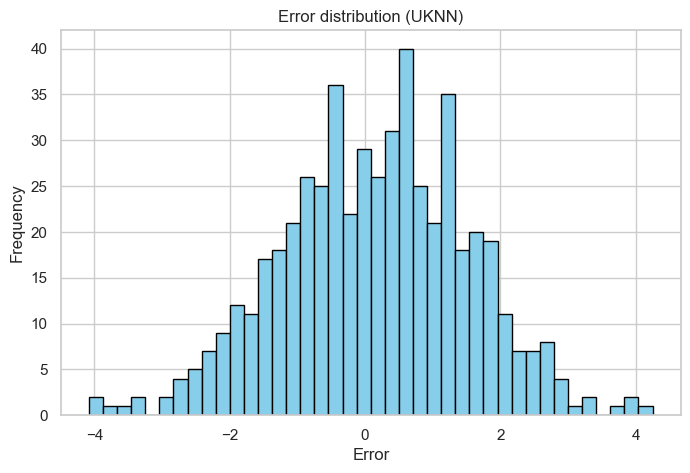

In [27]:
# UKNN error histogram

plt.figure(figsize=(8,5))
plt.hist(uknn_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (UKNN)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
iknn_errors = get_uknn_iknn_errors(iknn_adjusted, iknn_test_data)
iknn_errors.head()

userid  itemid  real_rating  predicted_rating     error
0    6504      17          3.0          3.670015 -0.670015
1    6092      28          5.0          3.765334  1.234666
2    9861      28          4.0          2.305041  1.694959
3    6504      28          4.0          3.738741  0.261259
4    3495      46          3.0          3.348062 -0.348062

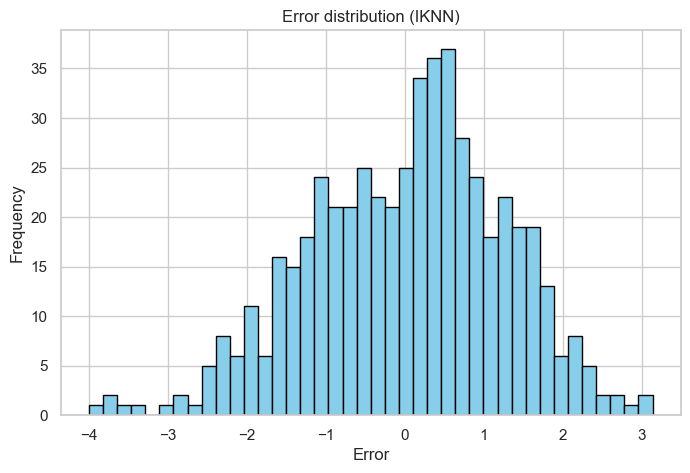

In [29]:
# IKNN error histogram

plt.figure(figsize=(8,5))
plt.hist(iknn_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (IKNN)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## SVD (Singular Value Decomposition)

We will use SVD to build a recommendation system based on latent factors. This approach helps uncover hidden relationships between users and items from existing rating patterns. Our goal is to obtain a dataframe with the ratings the model predicts.

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userid', 'itemid', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

# Train model
algo = SVD()
start_time = time.time()
algo.fit(trainset)
training_time = time.time() - start_time

predictions = algo.test(testset)

svd_errors = pd.DataFrame({
    'userid': [pred.uid for pred in predictions],
    'itemid': [pred.iid for pred in predictions],
    'real_rating': [pred.r_ui for pred in predictions],
    'predicted_rating': [pred.est for pred in predictions],
    'error': [pred.r_ui - pred.est for pred in predictions]
})

# Metrics
mae = mean_absolute_error(svd_errors['real_rating'], svd_errors['predicted_rating'])
rmse = np.sqrt(mean_squared_error(svd_errors['real_rating'], svd_errors['predicted_rating']))


In [31]:
print(f"Training time: {training_time:.4f} seconds")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Training time: 7.0441 seconds
MAE: 0.7137
RMSE: 0.9143


In [32]:
from src.utils import get_svd_predictions

all_pairs = set(product(user_ids, item_ids))
missing_pairs = all_pairs - existing_pairs

pred_df = pd.DataFrame(get_svd_predictions(algo, missing_pairs))
print(pred_df.head())

    userid  itemid  estimated_rating
0  2330798   10901          2.975173
1   306973    7756          3.467556
2   253064    1489          3.348571
3  2166063    4510          3.576566
4   975599    8011          4.081031


In [33]:
print(svd_errors.head())

    userid  itemid  rating_real  rating_predicho     error
0   178803    4262          4.0         4.163847 -0.163847
1   580992    4972          5.0         3.878016  1.121984
2  1674731    3826          3.0         3.520542 -0.520542
3   332234   14909          5.0         3.510698  1.489302
4  2403579    4193          4.0         3.035125  0.964875


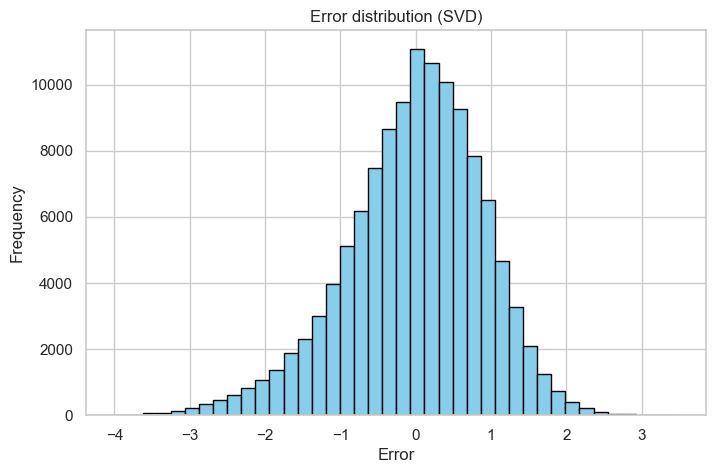

In [34]:
# SVD error histogram

plt.figure(figsize=(8,5))
plt.hist(svd_errors['error'], bins=40, color='skyblue', edgecolor='black')
plt.title('Error distribution (SVD)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Implicit Feedback

We will simulate binary implicit feedback. This simplifies the ratings to binary interactions for implicit recommendation models, focusing on whether a user interacted with an item, regardless of the rating's intensity. If the rating is 4 or higher, we generate a positive interaction (1). If the rating is below 4, we generate a negative interaction (0). For this task, we will use an ALS model to generate item recommendations for users.

In [35]:
df['interaction'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Map numeric indexes
user_map = {u: i for i, u in enumerate(df['userid'].unique())}
item_map = {i: j for j, i in enumerate(df['itemid'].unique())}
user_inv_map = {i: u for u, i in user_map.items()}
item_inv_map = {j: i for i, j in item_map.items()}

df['user_idx'] = df['userid'].map(user_map)
df['item_idx'] = df['itemid'].map(item_map)

In [36]:
# Sparse matrix (user x item)
sparse_matrix = coo_matrix(
    (df['interaction'], (df['user_idx'], df['item_idx']))
).tocsr()

als = AlternatingLeastSquares(
    factors=K,
    regularization=0.01,
    iterations=20,
    use_gpu=False
)

# Train model
start = time.time()
als.fit(sparse_matrix)
end = time.time()
print(f"Training time: {end - start:.4f} seconds")

c:\Users\n.esnal\bigdata\bigdatavenv\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:10<00:00,  1.93it/s]

Training time: 10.3673 seconds


In [37]:
# Get ALS recommendations
als_recommendations = defaultdict(list)
for user_id, user_idx in user_map.items():
    try:
        output = als.recommend(
            user_idx,
            sparse_matrix[user_idx],
            N=10,
            filter_already_liked_items = False
        )
        
        item_indices = output[0]
        scores = output[1]
        
        # Map to original ids
        als_recommendations[user_id] = [
            (item_inv_map[item_idx], float(score))
            for item_idx, score in zip(item_indices, scores)
        ]
    except Exception as e:
        print(f"Error with user {user_id}: {str(e)}")
        # Asign empty recommendation
        als_recommendations[user_id] = []

In [38]:
# For verification
success_count = sum(1 for recs in als_recommendations.values() if recs)
print(f"\nProcessed users: {len(als_recommendations)}")
print(f"Users with successful recommendations: {success_count}")
print(f"Users without recommendations: {len(als_recommendations) - success_count}")

# Show results
for user_id, recs in als_recommendations.items():
    print(f"\nRecommendations for user {user_id}:")
    for item_id, score in recs:
        print(f"  - Item: {item_id} (Score: {score:.4f})")


Processed users: 9992
Users with successful recommendations: 9992
Users without recommendations: 0

Recommendations for user 2567280:
  - Item: 7617 (Score: 1.2394)
  - Item: 4996 (Score: 1.0936)
  - Item: 15205 (Score: 1.0918)
  - Item: 7624 (Score: 1.0774)
  - Item: 14367 (Score: 1.0660)
  - Item: 3427 (Score: 1.0359)
  - Item: 2782 (Score: 1.0095)
  - Item: 15124 (Score: 0.9964)
  - Item: 1145 (Score: 0.9308)
  - Item: 13728 (Score: 0.8803)

Recommendations for user 1478381:
  - Item: 8644 (Score: 3.7201)
  - Item: 13359 (Score: 3.4863)
  - Item: 2743 (Score: 3.2526)
  - Item: 4951 (Score: 2.9731)
  - Item: 11173 (Score: 2.5653)
  - Item: 357 (Score: 2.2808)
  - Item: 10583 (Score: 2.1507)
  - Item: 8966 (Score: 1.7727)
  - Item: 4727 (Score: 1.6095)
  - Item: 11152 (Score: 1.5682)

Recommendations for user 1045221:
  - Item: 15124 (Score: 7.3631)
  - Item: 4656 (Score: 2.1786)
  - Item: 7617 (Score: 1.7001)
  - Item: 3427 (Score: 1.6992)
  - Item: 14410 (Score: 1.5615)
  - Item: 5

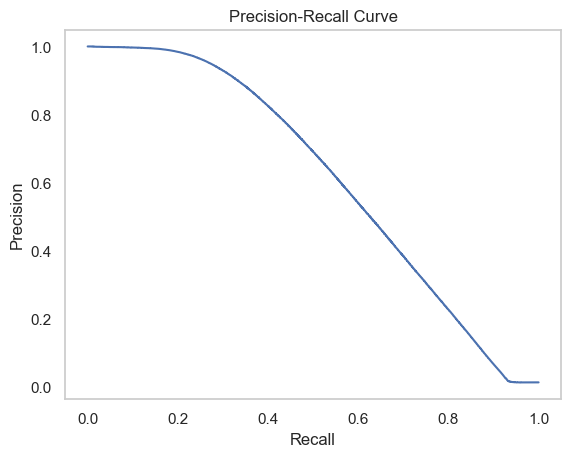

In [50]:
y_true = []
y_scores = []

real_interactions = set(zip(df['userid'], df['itemid']))

for user_id in user_map:
    for item_id in item_map:
        # Verify interaction
        real_interaction = 1 if (user_id, item_id) in real_interactions else 0
        y_true.append(real_interaction)

        # Obtain latent values
        user_vector = als.user_factors[user_map[user_id]]
        item_vector = als.item_factors[item_map[item_id]]
        predicted_score = np.dot(user_vector, item_vector)
        y_scores.append(predicted_score)

precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

## Explicit Feedback Model Comparison

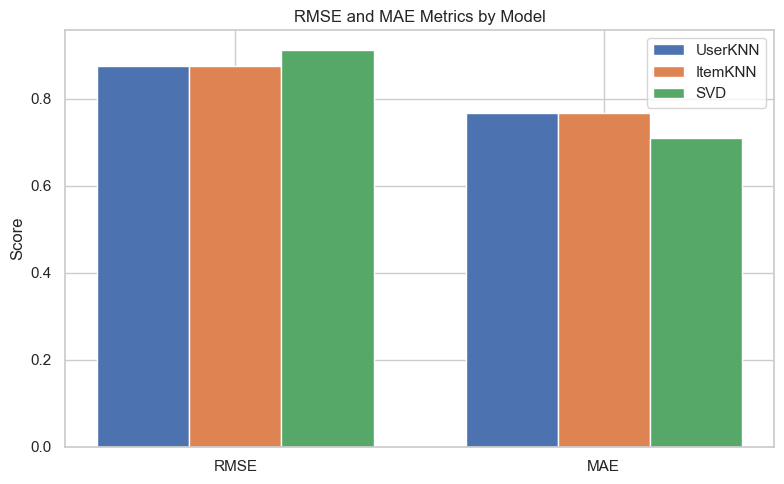

In [ ]:
# Barchart of RMSE and MAE comparison

metrics = ['RMSE', 'MAE']
models = {
    'UserKNN': [0.8751, 0.7671],
    'ItemKNN': [0.8749, 0.7683],
    'SVD':     [rmse, mae],
}

model_names = list(models.keys())
num_metrics = len(metrics)
x = np.arange(num_metrics)

bar_width = 0.25
offsets = [-bar_width, 0, bar_width]

fig, ax = plt.subplots(figsize=(8, 5))

for i, (model, scores) in enumerate(models.items()):
    ax.bar(x + offsets[i], scores, width=bar_width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("RMSE and MAE Metrics by Model")
ax.legend()

plt.tight_layout()
plt.show()

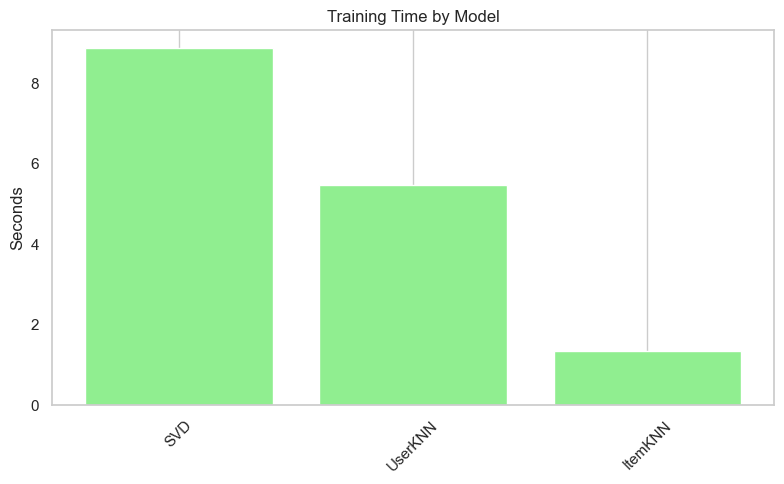

In [ ]:
# Training time comparison

training_times = {
    'SVD': training_time,
    'UserKNN': 5.4736,
    'ItemKNN': 1.3446
}

models = list(training_times.keys())
times = list(training_times.values())

plt.figure(figsize=(8,5))
plt.bar(models, times, color='lightgreen')
plt.title('Training Time by Model')
plt.ylabel('Seconds')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


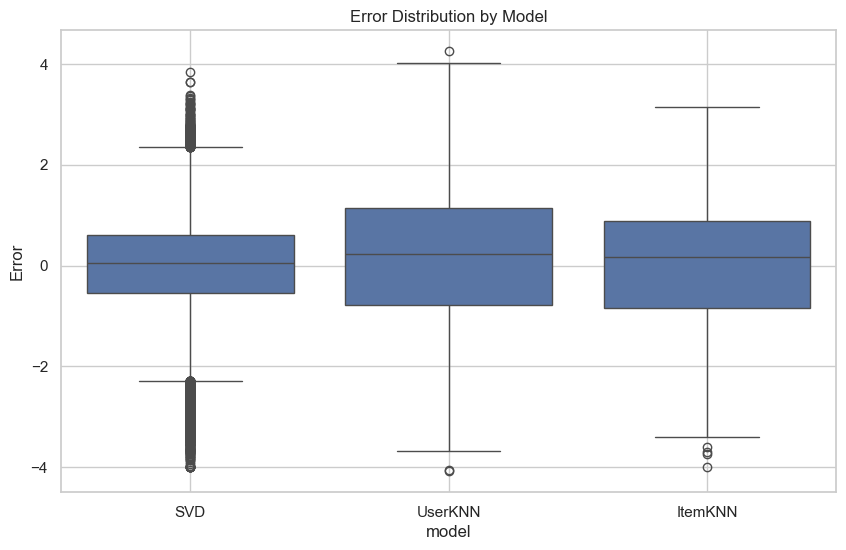

In [ ]:
# Error distribution comparison

svd_errors['model'] = 'SVD'
uknn_errors['model'] = 'UserKNN'
iknn_errors['model'] = 'ItemKNN'

df_errors = pd.concat([svd_errors, uknn_errors, iknn_errors])

plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='error', data=df_errors)
plt.title('Error Distribution by Model')
plt.ylabel('Error')
plt.grid(True)
plt.show()